# A/B-тест

## Настройки

In [1]:
import pandahouse
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Сделаем графики в seaborn покрупнее
sns.set(rc={'figure.figsize':(15, 10)})

In [3]:
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20230720'
}

## Задача

Пришло время проанализировать результаты эксперимента, который мы провели вместе с командой дата сайентистов. Эксперимент проходил с 2023-06-30 по 2023-07-06 включительно. Для эксперимента были задействованы 2 и 1 группы. 

В группе 2 был использован один из новых алгоритмов рекомендации постов, группа 1 использовалась в качестве контроля. 

Основная гипотеза заключается в том, что новый алгоритм во 2-й группе приведет к увеличению CTR. 

Ваша задача — проанализировать данные А/B-теста. 

1. Выбрать метод анализа и сравнить CTR в двух группах (мы разбирали t-тест, Пуассоновский бутстреп, тест Манна-Уитни, t-тест на сглаженном ctr (α=5) а также t-тест и тест Манна-Уитни поверх бакетного преобразования).
2. Сравните данные этими тестами. А еще посмотрите на распределения глазами. Почему тесты сработали именно так? 
3. Опишите потенциальную ситуацию, когда такое изменение могло произойти. Тут нет идеального ответа, подумайте.
4. Напишите рекомендацию, будем ли мы раскатывать новый алгоритм на всех новых пользователей или все-таки не стоит.

## Тесты

In [4]:
%%time
# Эксперимент проходил с 2023-06-30 по 2023-07-06 включительно
# Для эксперимента были задействованы 2 и 1 группы.
# В группе 2 был использован один из новых алгоритмов рекомендации постов, группа 1 использовалась в качестве контроля.
q = """
SELECT 
    exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2023-06-30' and '2023-07-06'
    and exp_group in (1, 2)
GROUP BY exp_group, user_id
"""

df = pandahouse.read_clickhouse(q, connection=connection)

CPU times: user 30.1 ms, sys: 13.5 ms, total: 43.6 ms
Wall time: 456 ms


In [5]:
# Сколько строк?
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19897 entries, 0 to 19896
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   exp_group  19897 non-null  int8   
 1   user_id    19897 non-null  uint32 
 2   likes      19897 non-null  uint64 
 3   views      19897 non-null  uint64 
 4   ctr        19897 non-null  float64
dtypes: float64(1), int8(1), uint32(1), uint64(2)
memory usage: 563.6 KB


In [6]:
df.head(10)

,exp_group,user_id,likes,views,ctr
0,1,109963,3,15,0.200000
1,1,26117,32,141,0.226950
2,1,138232,18,73,0.246575
3,1,18392,7,32,0.218750
4,1,26295,39,141,0.276596
5,2,131473,9,108,0.083333
6,2,23985,7,87,0.080460
7,2,32420,13,44,0.295455
8,2,24523,11,101,0.108911
9,2,24239,40,90,0.444444


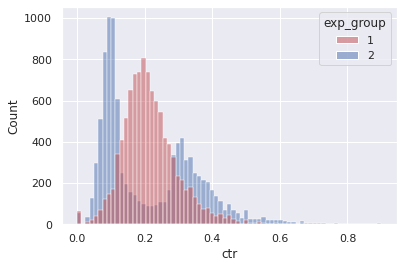

In [7]:
# Посмотрим распределения CTR в группах 1 и 2
groups = sns.histplot(data = df, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

* Вторая группа разбилась на 2 подгруппы: видно, что распределение стало бимодальным; у части пользователей CTR увеличился, у другой - уменьшился.
* Возможно, что-то сломалось при работе алгоритма рекомендации: на части пользоваталей он просто не сработал по техническим причинам. 
* Если пользователи разбились на 2 группы по естественным причинам (по своим предпочтениям, из-за того, что алгоритм невосприимчив к одной из групп), то имеет смысл понть чем отличаются эти группы. Тогда можно будет применять алгоритм только для той части аудитории, которая к нему более восприимчива.

In [8]:
# Есть ли разница в среднем количестве просмотров? Как будто бы и нет
df. groupby('exp_group').agg({'ctr': ['mean', 'median'], 'views': ['mean', 'median']})

ctr                views       
               mean    median       mean median
exp_group                                      
1          0.216774  0.205882  66.820659   57.0
2          0.216102  0.153285  66.766630   57.0

In [9]:
df.columns

Index(['exp_group', 'user_id', 'likes', 'views', 'ctr'], dtype='object')

### Простой t-тест

С учётом того, что распределение во второй группе бимодальное, t-test сработать не должен.

In [10]:
df_gr1 = df[df['exp_group'] == 1]  # группа, в которой всё по-старому
df_gr2 = df[df['exp_group'] == 2]  # группа с рекомендацией постов

In [11]:
stats.ttest_ind(df_gr1['ctr'],
                df_gr2['ctr'],
                equal_var=False)

Ttest_indResult(statistic=0.4051491913112757, pvalue=0.685373331140751)

### Тест Манна-Уитни

In [12]:
stats.mannwhitneyu(df_gr1['ctr'],
                   df_gr2['ctr'])

MannwhitneyuResult(statistic=55189913.0, pvalue=4.632205841806026e-45)

### Сглаживание CTR

Помочь не должно, но попрактикуемся :)

In [13]:
def get_smothed_ctr(user_likes, user_views, global_ctr, alpha):
    smothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smothed_ctr

In [14]:
# общий CTR по группе внутри группы 1 (контрольная)
global_ctr_1 = df_gr1['likes'].sum() / df_gr1['views'].sum()
global_ctr_1

0.2096041628394293

In [15]:
# общий CTR по группе внутри группы 2 (тестирование алгоритма рекомендации)
global_ctr_2 = df_gr2['likes'].sum() / df_gr2['views'].sum()
global_ctr_2

0.20025051027061783

<Axes: xlabel='smothed_ctr', ylabel='Count'>

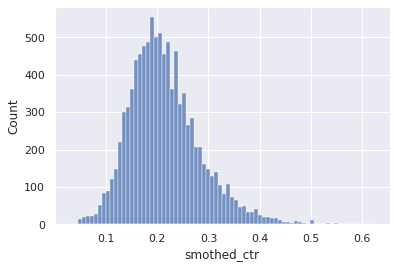

In [16]:
df_gr1['smothed_ctr'] = df_gr1.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_1, 5), axis=1)

sns.histplot(df_gr1['smothed_ctr'], 
             kde = False)

<Axes: xlabel='smothed_ctr', ylabel='Count'>

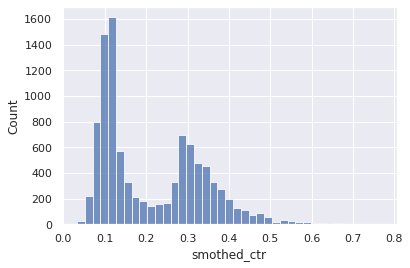

In [17]:
df_gr2['smothed_ctr'] = df_gr2.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_1, 5), axis=1)

sns.histplot(df_gr2['smothed_ctr'], 
             kde = False)

In [18]:
stats.ttest_ind(df_gr1['smothed_ctr'],
                df_gr2['smothed_ctr'],
                equal_var=False)

Ttest_indResult(statistic=1.2447034376197188, pvalue=0.2132595139151033)

### Пуассоновский бутсреп

In [19]:
df_gr1

,exp_group,user_id,likes,views,ctr,smothed_ctr
0,1,109963,3,15,0.200000,0.202401
1,1,26117,32,141,0.226950,0.226356
2,1,138232,18,73,0.246575,0.244205
3,1,18392,7,32,0.218750,0.217514
4,1,26295,39,141,0.276596,0.274302
...,...,...,...,...,...,...
19886,1,31540,7,39,0.179487,0.182910
19887,1,23359,12,32,0.375000,0.352649
19890,1,110956,3,16,0.187500,0.192763
19891,1,132567,52,326,0.159509,0.160266


In [20]:
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):

    poisson_bootstraps1 = stats.poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)

    poisson_bootstraps2 = stats.poisson(1).rvs(
            (n_bootstrap, len(likes2))).astype(np.int64)
    
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)

    return globalCTR1, globalCTR2


likes1 = df_gr1['likes'].to_numpy()
views1 = df_gr1['views'].to_numpy()
likes2 = df_gr2['likes'].to_numpy()
views2 = df_gr2['views'].to_numpy()

ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)

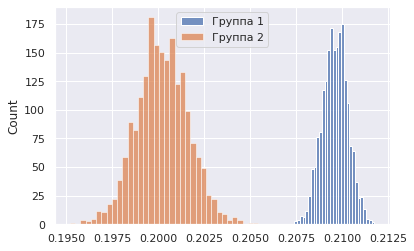

In [21]:
import matplotlib.pyplot as plt

sns.histplot(ctr1, label='Группа 1')
sns.histplot(ctr2, label='Группа 2')
plt.legend()
plt.show()

<Axes: ylabel='Count'>

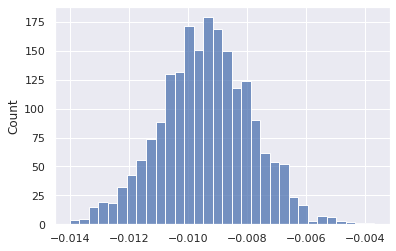

In [22]:
sns.histplot(ctr2 - ctr1)

Видно, что глобальный CTR группы 2 хуже, чем у контрольной группы 1. 

In [23]:
# И проведём t-тест
stats.ttest_ind(ctr1,
                ctr2,
                equal_var=False)

Ttest_indResult(statistic=267.4518882498454, pvalue=0.0)

### Бакетное преобразование

Надо разбить пользователей на n «корзинок» («бакетов»). Нужно гарантировать, что 
* каждый пользователь попадет только в один бакет;
* и пользователи по бакетам будут распределены равномерно.

#### В pandas

In [24]:
n_buckets = 100

# Вычисления для контрольной группы
buckets_gr1 = np.array_split(df_gr1['ctr'], n_buckets)  # разбиваем стобец CTR на 50 подвыборок / бакетов. В каждой будет примерно по 200 пользователей
ctr_means_gr1 = [b.mean() for b in buckets_gr1]  # вычисляем средние значения CTR для каждой из подвыборок 
ctr_means_gr1 = np.array(ctr_means_gr1)

# Для тестовой
buckets_gr2 = np.array_split(df_gr2['ctr'], n_buckets)  # разбиваем стобец CTR на 50 подвыборок / бакетов. В каждой будет примерно по 200 пользователей
ctr_means_gr2 = [b.mean() for b in buckets_gr2]  # вычисляем средние значения CTR для каждой из подвыборок
ctr_means_gr2 = np.array(ctr_means_gr2)

In [25]:
# Средние очень близки
ctr_means_gr1.mean(), ctr_means_gr2.mean()

(0.21677867220217506, 0.21610542475519043)

<Axes: ylabel='Count'>

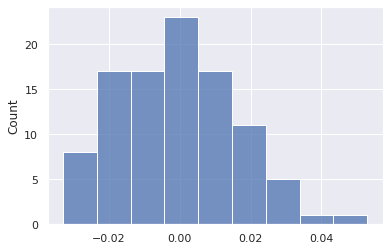

In [26]:
# Посмотрим на распределение разностей средних
sns.histplot(ctr_means_gr2 - ctr_means_gr1)

<Axes: ylabel='Density'>

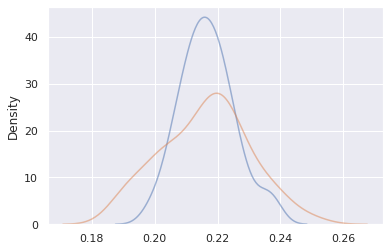

In [27]:
# Посмотрим распределения средних CTR в группах 1 и 2
sns.kdeplot(ctr_means_gr1, alpha=0.5)
sns.kdeplot(ctr_means_gr2, alpha=0.5)

In [28]:
# И проведём t-тест
stats.ttest_ind(ctr_means_gr1,
                ctr_means_gr2,
                equal_var=False)

Ttest_indResult(statistic=0.40786655373133746, pvalue=0.6839006408491487)

## Выводы

1. Визуальный анализ
    * Тестовая группа группа разбилась на 2 подгруппы: видно, что распределение стало бимодальным; у части пользователей CTR увеличился, у другой - уменьшился. 
    * Возможно, что-то сломалось при работе алгоритма рекомендации: на части пользоваталей он просто не сработал по техническим причинам. 
    * Возможно, алгоритм по-разному работает для разных групп пользователей. Тогда если пользователи разбились на 2 группы по естественным причинам (по своим предпочтениям, из-за того, что алгоритм невосприимчив к одной из групп), то имеет смысл понть, чем отличаются эти группы – например, - решить задачу задачу кластеризации (или задачу восстановления плотности распределения, чтобы явно разделить группы пользоваталей), а затем задачу классификации, чтобы научиться определять пользователей, для которых новая рекомендатальная система отработала хорошо. Далее можно будет применять алгоритм только для той части аудитории, которая к нему более восприимчива.
2. Анализ с помощью статистических критериев
    * t-тест: распределение во второй группе бимодальное, t-test не сработал. t-test при сравнении сглаживанных CTR также не выявил статистически значимых отличий.
    * Тест Манна-Уитни показал значимое отличие.
    * Пуассоновский бутсреп показал, что глобальный CTR группы 2 хуже, чем у контрольной группы 1.
    * t-тест поверх бакеттного преобразования не выявил отличий.
2. В текущем виде внедрять новый алгоритм для всех новых пользователей не стоит.
3. Стоит выявить пользователей, для которых новый алгоритм показад увеличение CTR и запустить другое тестирование на пользователях выявленного типа для тестирования того же алгоритма рекомендаций. 